# FastSAM
<a target="blank" href="https://colab.research.google.com/github/mora-bprs/SAM-model/blob/thuva/fastSAM.ipynb">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

---
# 1. Environment Setup
---

In [90]:
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import gdown
import shutil
from random import randint
from yachalk import chalk as c

by = c.bold.yellow_bright
br = c.bold.red_bright
bg = c.bold.green_bright
bb = c.bold.blue_bright
bm = c.bold.magenta_bright
bc = c.bold.cyan_bright

###############
COLAB = False  # edit this to True in Google Colab
###############

print(f"{by('PyTorch')} v{torch.__version__}")
print(f"{by('Torchvision')} v{torchvision.__version__}")
CUDA = torch.cuda.is_available()
MPS = torch.backends.mps.is_available()
print(f"{bg('CUDA')} Available: {bg(CUDA) if CUDA else br(CUDA)}")
print(f"{bb('MPS')} Available: {bg(MPS) if MPS else br(MPS)}")
device = "cuda" if CUDA else "cpu"
ROOT = os.getcwd() if not COLAB else "/content"
print(bc("Working Directory:"), ROOT)
print(by("Google Colab") if COLAB else bm("Local") + " Environment Configured")

PyTorch v2.3.0
Torchvision v0.18.0
CUDA Available: False
MPS Available: True
Working Directory: /Users/tony/dev/SAM-model
Local Environment Configured


## Test dataset setup

In [44]:
RESET_DATASET = False
if not os.path.exists("train") or RESET_DATASET:
    shutil.rmtree("train", ignore_errors=True)
    gdown.download(
        "https://drive.google.com/uc?id=1iWaDuDQKftRDZ_poWyEua7j6_leDhDQc",
        "box_train.zip",
        quiet=False,
    )
    !unzip box_train.zip
    os.remove("box_train.zip")
else:
    print(bg("Skipping: Dataset already downloaded"))

DATASET_PATH = f"{ROOT}/train"

Skipping: Dataset already downloaded


## FastSAM package & Pretrained weights setup

In [45]:
# download FastSAM and weights
RESET_FASTSAM = False
if RESET_FASTSAM or not os.path.exists("FastSAM"):
    if os.path.exists("FastSAM"):
        shutil.rmtree("FastSAM", ignore_errors=False)
    !git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
    !wget https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
else:
    print(bg("Skipping: FastSAM already downloaded"))

Skipping: FastSAM already downloaded


In [46]:
#####################
INITIALIZED = True  # edit this to False if running for the first time
#####################
if not INITIALIZED:
    if COLAB:
        %pip install segment-anything-fast
    else:
        pass
        # %pip install -r requirements.txt
    %pip install -r FastSAM/requirements.txt
    %pip install git+https://github.com/openai/CLIP.git
else:
    print(bg("Skipping: Dependencies already installed"))

Skipping: Dependencies already installed


In [47]:
### downloading FastSAM weights (pretrained model checkpoints)
# two model versions of the model are available with different sizes.
# `FastSAM` will be referred as `FastSAM-x` (https://drive.google.com/file/d/1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv/view)
# `FastSAM-s` (https://drive.google.com/file/d/10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV/view)

RESET_FASTSAM = False
if RESET_FASTSAM:
    if os.path.exists("FastSAM-s.pt"):
        os.remove("FastSAM-s.pt")
    if os.path.exists("FastSAM-x.pt"):
        os.remove("FastSAM-x.pt")
if not os.path.exists("FastSAM-s.pt"):
    gdown.download(
        "https://drive.google.com/uc?id=10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV",
        "FastSAM-s.pt",
        quiet=False,
    )
if not os.path.exists("FastSAM-x.pt"):
    gdown.download(
        "https://drive.google.com/uc?id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv",
        "FastSAM-x.pt",
        quiet=False,
    )
print(bg("FastSAM Weights Configured"))

FastSAM Weights Configured


In [48]:
from fastsam import FastSAM, FastSAMPrompt

# model_type = "vit_h"
model_fastsam_x = FastSAM(f"{ROOT}/FastSAM-x.pt")
model_fastsam_s = FastSAM(f"{ROOT}/FastSAM-s.pt")
print(by("FastSAM Models Loaded and ready for action"))

FastSAM Models Loaded and ready for action


## Helper Functions

In [97]:
DETAILED_LOGS = False
TARGET_SIZE = 960
FASTSAM_X = 0
FASTSAM_S = 1
# SAM = 2 # not available yet

################################
### General Utility Functions
################################


def log(*args):
    if DETAILED_LOGS:
        print(*args)


def crop_n_resize(img_path, target_size):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    min_dim = min(h, w)
    x = (w - min_dim) // 2
    y = (h - min_dim) // 2
    cropped = img[y : y + min_dim, x : x + min_dim]
    resized = cv2.resize(cropped, (target_size, target_size))
    if DETAILED_LOGS:
        h_new, w_new = resized.shape[:2]
        log(f"{w}x{h} -> {w_new}x{h_new}")
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(img)
        ax[1].imshow(resized)
        plt.show()
    return resized


def get_center_coords(image):
    h, w, _ = image.shape
    center_coords = [int(w / 2), int(h / 2)]
    if DETAILED_LOGS:
        print(bb("get_center_coords function"))
        print(f"Image resolution: {w}x{h}")
        print(f"Center Coordinates: {center_coords}")
    # return np.array([center_point_coords]), np.array([1])
    return np.array([center_coords])


def list_image_files(directory):
    image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp"]  # Add more if needed
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_files.append(os.path.join(root, file))
    return image_files


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def plot_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("on")
    plt.show()


################################
### Plotting Utility Functions
################################


def plot_images(image1, image2, image3, image4):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(image1)
    ax[0, 0].axis("on")
    ax[0, 1].imshow(image2)
    ax[0, 1].axis("on")
    ax[1, 0].imshow(image3)
    ax[1, 0].axis("on")
    ax[1, 1].imshow(image4)
    ax[1, 1].axis("on")
    plt.show()


def plot_images_with_center_coords(image1, image2, image3, image4):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(image1)
    ax[0, 0].axis("on")
    show_points(*get_center_coords(image1), 1, ax[0, 0])
    ax[0, 1].imshow(image2)
    ax[0, 1].axis("on")
    show_points(*get_center_coords(image2), 1, ax[0, 1])
    ax[1, 0].imshow(image3)
    ax[1, 0].axis("on")
    show_points(*get_center_coords(image3), 1, ax[1, 0])
    ax[1, 1].imshow(image4)
    ax[1, 1].axis("on")
    show_points(*get_center_coords(image4), 1, ax[1, 1])
    plt.show()


def fastsam_maskgen(
    model, image, device=device, retina_masks=True, imgsz=TARGET_SIZE, conf=0.4, iou=0.9
):
    """
    utility function to easily generate masks from FastSAM models
    """
    if model == FASTSAM_X:
        return FastSAMPrompt(
            image,
            model_fastsam_x(
                image,
                device=device,
                retina_masks=retina_masks,
                imgsz=imgsz,
                conf=conf,
                iou=iou,
            ),
            device=device,
        ).point_prompt(points=get_center_coords(image), pointlabel=[1])[0]
    elif model == FASTSAM_S:
        return FastSAMPrompt(
            image,
            model_fastsam_s(
                image,
                device=device,
                retina_masks=retina_masks,
                imgsz=imgsz,
                conf=conf,
                iou=iou,
            ),
            device=device,
        ).point_prompt(points=get_center_coords(image), pointlabel=[1])[0]
    else:
        return "Invalid model"


def plot_images_with_mask(model, image1, image2, image3, image4):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(image1)
    ax[0, 0].imshow(fastsam_maskgen(model, image1), alpha=0.5)
    ax[0, 1].imshow(image2)
    ax[0, 1].imshow(fastsam_maskgen(model, image2), alpha=0.5)
    ax[1, 0].imshow(image3)
    ax[1, 0].imshow(fastsam_maskgen(model, image3), alpha=0.5)
    ax[1, 1].imshow(image4)
    ax[1, 1].imshow(fastsam_maskgen(model, image4), alpha=0.5)
    plt.show()


def plot_diff_masks(image, m1, m2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image)
    ax[0].imshow(fastsam_maskgen(m1, image), alpha=0.5)
    ax[0].set_title("FastSAM-x", fontsize=18)
    ax[0].axis("off")
    ax[1].imshow(image)
    ax[1].imshow(fastsam_maskgen(m2, image), alpha=0.5)
    ax[1].set_title("FastSAM-s", fontsize=18)
    ax[1].axis("off")

    plt.show()


print(bg("Functions All Set! Ready to go!"))

Functions All Set! Ready to go!


## Verification of Dataset and Functions

In [65]:
image_paths = list_image_files(DATASET_PATH)
TARGET_SIZE = 960


img_arr = []
for i, img_pth in enumerate(image_paths):
    img_arr.append(crop_n_resize(img_pth, TARGET_SIZE))
    img_arr[i] = cv2.cvtColor(img_arr[i], cv2.COLOR_BGR2RGB)
print(
    f"{bg(len(img_arr))} images cropped and resized to {br(TARGET_SIZE,'x', TARGET_SIZE)}"
)

111 images cropped and resized to 960 x 960


Image resolution: 960x960
Image resolution: 960x960
Image resolution: 960x960
Image resolution: 960x960


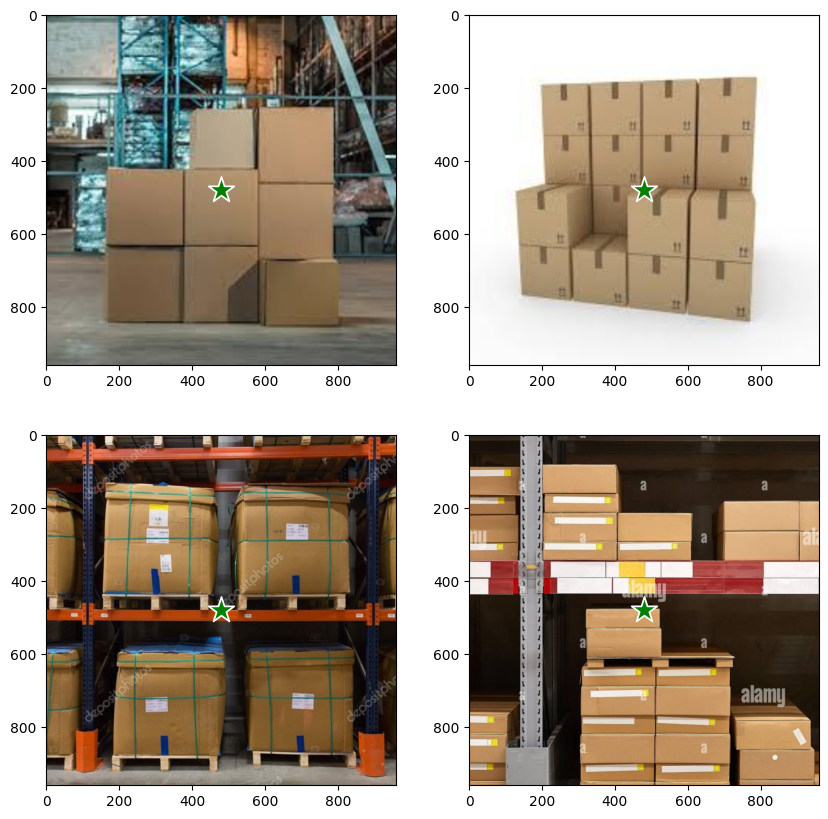

In [51]:
plot_images_with_center_coords(*img_arr[0:4])

___
# 2. Evaluating FastSAM-x
---

0: 960x960 23 objects, 1663.7ms
Speed: 15.8ms preprocess, 1663.7ms inference, 30.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 25 objects, 1363.8ms
Speed: 2.3ms preprocess, 1363.8ms inference, 35.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 60 objects, 1278.1ms
Speed: 1.6ms preprocess, 1278.1ms inference, 63.8ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 119 objects, 1330.8ms
Speed: 1.4ms preprocess, 1330.8ms inference, 209.5ms postprocess per image at shape (1, 3, 960, 960)


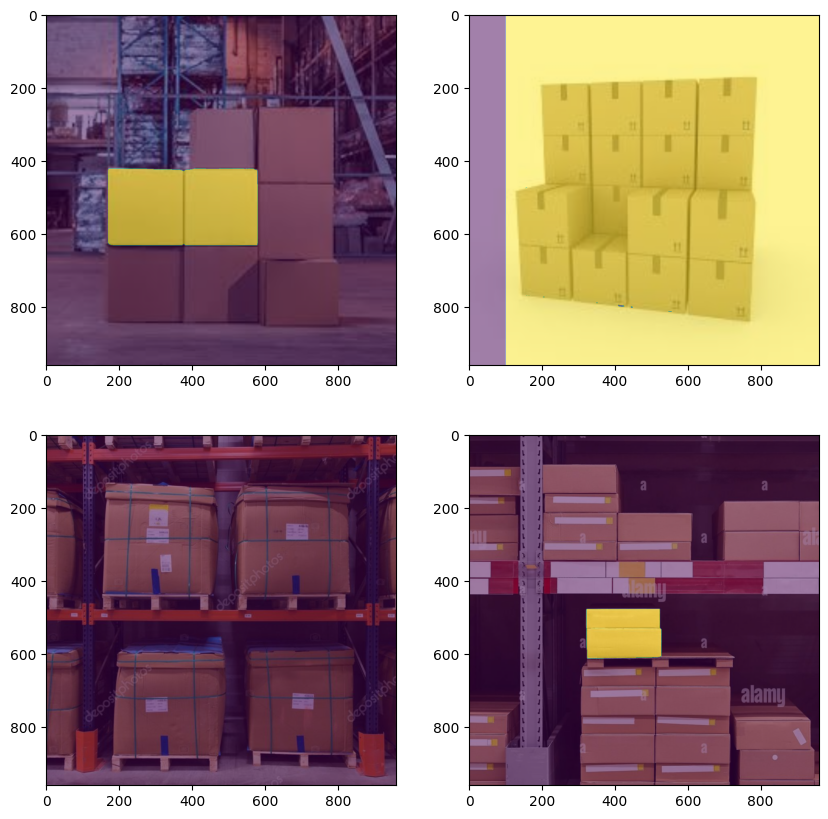

In [98]:
plot_images_with_mask(0, *img_arr[0:4])

---
## Evaluating FastSAM-s
---


0: 960x960 21 objects, 327.8ms
Speed: 2.1ms preprocess, 327.8ms inference, 29.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 23 objects, 317.3ms
Speed: 1.6ms preprocess, 317.3ms inference, 25.9ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 65 objects, 296.3ms
Speed: 2.8ms preprocess, 296.3ms inference, 112.7ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 140 objects, 267.8ms
Speed: 1.6ms preprocess, 267.8ms inference, 285.0ms postprocess per image at shape (1, 3, 960, 960)


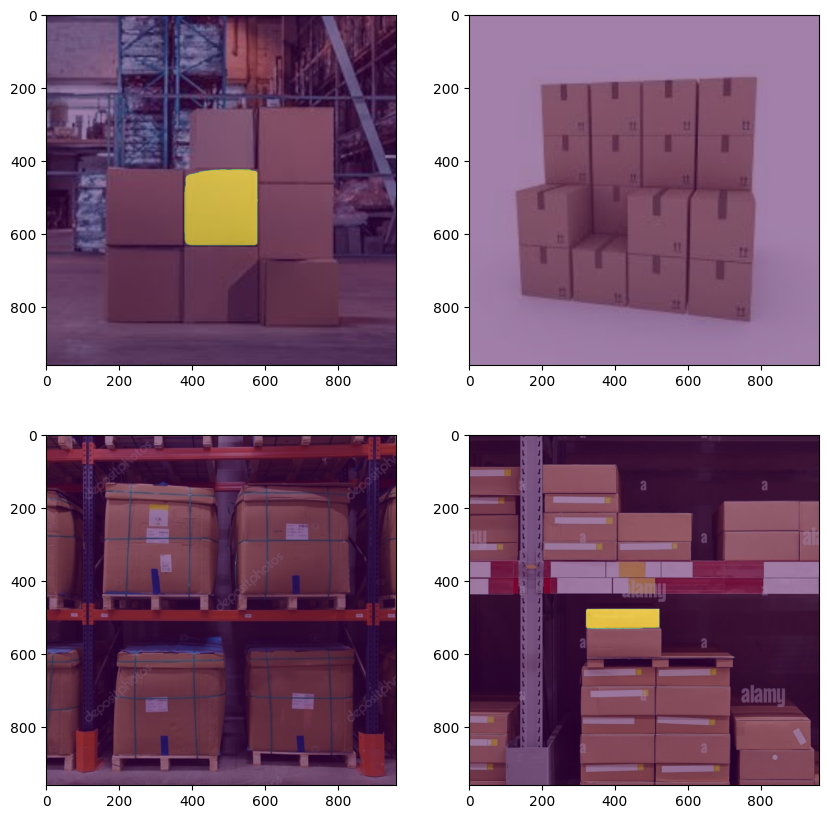

In [99]:
plot_images_with_mask(1, *img_arr[0:4])

---
# Comparing FastSAM-x and FastSAM-s
---

0: 960x960 23 objects, 1461.0ms
Speed: 2.3ms preprocess, 1461.0ms inference, 24.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 21 objects, 258.3ms
Speed: 1.5ms preprocess, 258.3ms inference, 23.5ms postprocess per image at shape (1, 3, 960, 960)


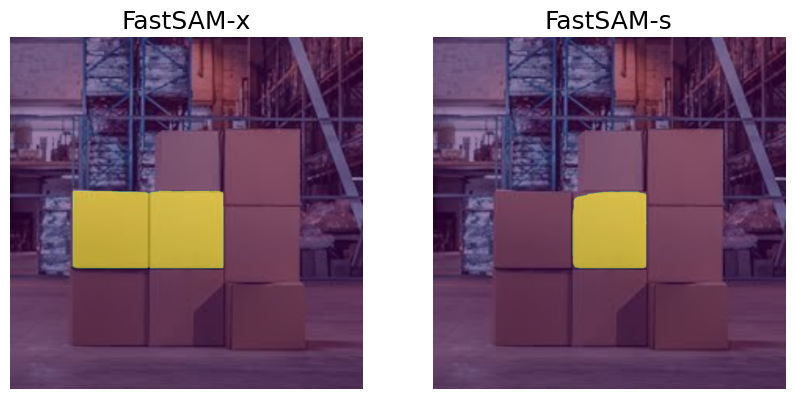


0: 960x960 25 objects, 1309.0ms
Speed: 1.6ms preprocess, 1309.0ms inference, 29.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 23 objects, 270.5ms
Speed: 1.5ms preprocess, 270.5ms inference, 19.5ms postprocess per image at shape (1, 3, 960, 960)


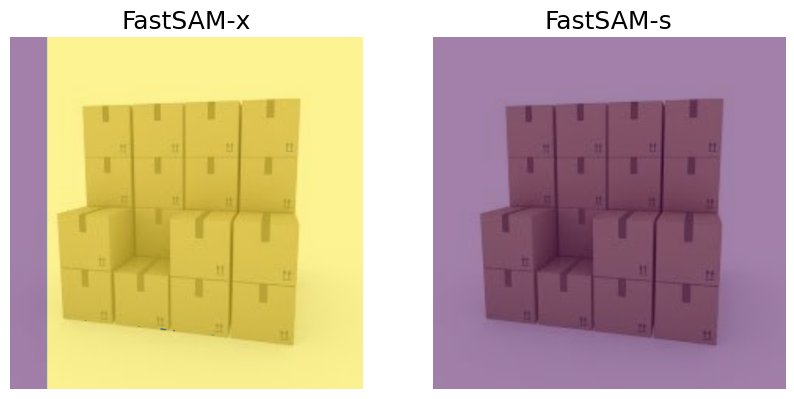


0: 960x960 60 objects, 1327.5ms
Speed: 1.9ms preprocess, 1327.5ms inference, 62.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 65 objects, 276.9ms
Speed: 1.6ms preprocess, 276.9ms inference, 75.1ms postprocess per image at shape (1, 3, 960, 960)


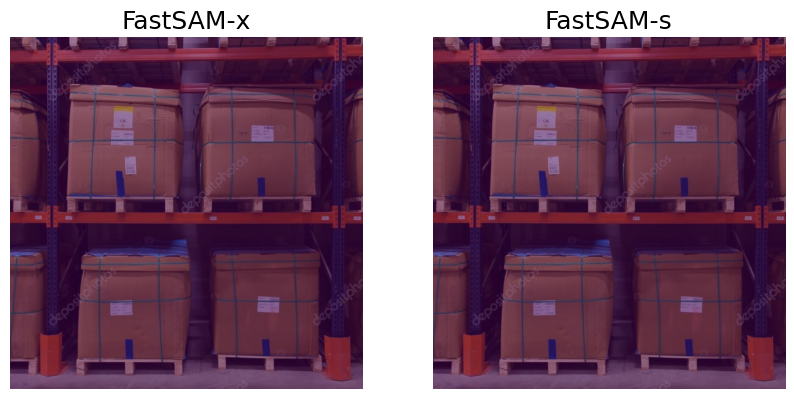


0: 960x960 119 objects, 1299.5ms
Speed: 2.1ms preprocess, 1299.5ms inference, 170.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 140 objects, 282.2ms
Speed: 1.6ms preprocess, 282.2ms inference, 333.0ms postprocess per image at shape (1, 3, 960, 960)


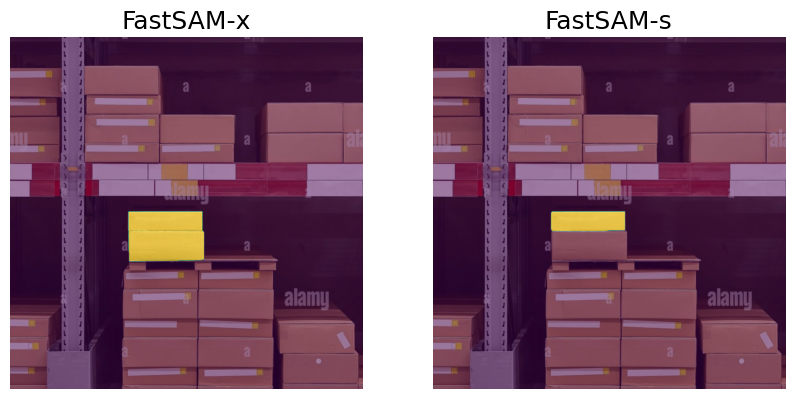

In [100]:
# x_mask = fastsam_maskgen(0, img_arr[0])
# s_mask = fastsam_maskgen(1, img_arr[0])

# # ANNOTATED_PATH = f"{ROOT}/annotate/box.jpg"
# # BUG: tkinter kernel crash, unexpected behavior
# # fast_sam_prompt_process.plot(annotations=mask,output_path=ANNOTATED_PATH)

# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(x_mask, interpolation="none")
# ax[1].imshow(s_mask, interpolation="none")
# # show_mask(x_mask, ax[0])
# # show_mask(s_mask, ax[1])
# plt.show()


# TODO: utilize show_mask function to plot the masks
for i in range(4):
    plot_diff_masks(img_arr[i], 0, 1)

---
# Coordinate Detections
---

In [101]:
wild_guess = randint(0, len(img_arr) - 1)
sample_image = img_arr[wild_guess]
sample_mask = fastsam_maskgen(1, sample_image)
DETAILED_LOGS = True
if DETAILED_LOGS:
    print(f"Random Image: {wild_guess}")
    print(f"Image Array Element Type: {type(sample_image)}")
    print(f"Image Array Element Shape: {sample_image.shape}")
    print(f"Sample Mask Type: {type(sample_mask)}")
    print(f"Sample Mask Shape: {sample_mask.shape}")


# TODO: check whether below is needed
# ? The mask and the image are not in the correct matching dimensions. We have to map this one.
# reshaped_mask = np.transpose(sample_mask, (1, 2, 0))
# reshaped_mask.shape

0: 960x960 17 objects, 274.7ms
Speed: 2.8ms preprocess, 274.7ms inference, 24.0ms postprocess per image at shape (1, 3, 960, 960)


Random Image: 94
Image Array Element Type: <class 'numpy.ndarray'>
Image Array Element Shape: (960, 960, 3)
Sample Mask Type: <class 'numpy.ndarray'>
Sample Mask Shape: (960, 960)


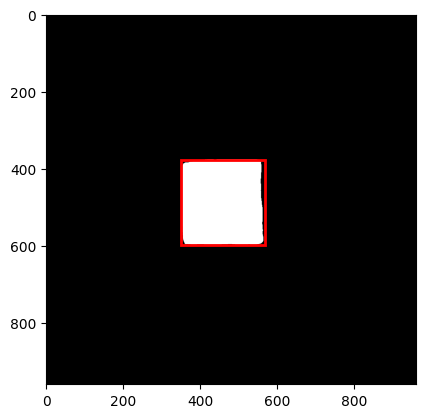

In [102]:
def plot_square(mask):
    # find the indices where the mask is true
    true_indices = np.argwhere(mask)
    # get the bounding box of the true region
    top_l = np.min(true_indices, axis=0)
    bot_r = np.max(true_indices, axis=0)
    # calculate the width and height of the bounding box
    w = bot_r[1] - top_l[1]
    h = bot_r[0] - top_l[0]

    fig, ax = plt.subplots(1)
    # plot the mask
    ax.imshow(mask, cmap="gray")
    # create a rectangle patch
    rect = patches.Rectangle(
        (top_l[1], top_l[0]), w, h, linewidth=2, edgecolor="r", facecolor="none"
    )
    # add the rectangle patch to the axis
    ax.add_patch(rect)
    plt.show()


plot_square(sample_mask)

In [112]:
def get_bounding_box_coordinates(mask):
    # find the indices where the mask is true
    true_indices = np.argwhere(mask)

    # get the bounding box of the true region
    top_l = np.min(true_indices, axis=0)
    bot_r = np.max(true_indices, axis=0)

    # calculate the width and height of the bounding box
    w = bot_r[1] - top_l[1]
    h = bot_r[0] - top_l[0]

    # calculate the coordinates of the corners
    top_r = (top_l[1] + w, top_l[0])
    bot_l = (top_l[1], top_l[0] + h)
    bot_r = (top_l[1] + w, top_l[0] + h)
    top_l = (top_r[0] - (bot_r[0] - bot_l[0]), (top_r[1] - bot_r[1]) + bot_l[1])

    if DETAILED_LOGS:
        print("Bounding Box Coordinates")
        print("Top left:", top_l)
        print("Top right:", top_r)
        print("Bottom left:", bot_l)
        print("Bottom right:", bot_r)

    return [top_l, top_r, bot_l, bot_r]


bound_coords = get_bounding_box_coordinates(sample_mask)

Bounding Box Coordinates
Top left: (351, 377)
Top right: (569, 377)
Bottom left: (351, 598)
Bottom right: (569, 598)


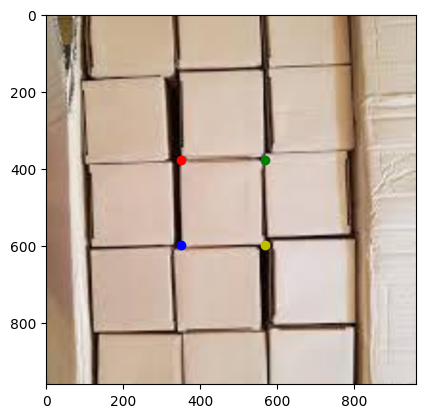

In [108]:
def annotate_square_corners(
    image, top_left, top_right, bottom_left, bottom_right, save_path
):
    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Plot the original image
    ax.imshow(image)

    # Annotate the corners
    ax.plot(top_left[0], top_left[1], "ro")  # Top Left corner
    ax.plot(top_right[0], top_right[1], "go")  # Top Right corner
    ax.plot(bottom_left[0], bottom_left[1], "bo")  # Bottom Left corner
    ax.plot(bottom_right[0], bottom_right[1], "yo")  # Bottom Right corner

    # Save the plot to the specified path
    plt.savefig(save_path)
    plt.show()


annotate_square_corners(
    sample_image,
    *get_bounding_box_coordinates(sample_mask),
    f"{ROOT}/annotate/box_img_{wild_guess}.jpg",
)

---
# Pipeline WIP
---

In [ ]:
def get_box_coordinates_fast_sam(
    image_path: str,
    model_path: str,
    isFastSAM=True,
    showOriginalImage=False,
    showPoints=True,
    showPlotMaskWithHighestScore=True,
):
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # plot original image
    if showOriginalImage:
        plot_image(img)

    # get image dimensions
    img_height, img_width, _ = img.shape

    # get centre point coordinates
    center_point_coords = [int(img_width / 2), int(img_height / 2)]
    input_point = np.array([center_point_coords])
    input_label = np.array([1])

    if showPoints:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        show_points(input_point, input_label, plt.gca())
        plt.axis("on")
        plt.show()

    # draw a rectangle that makes the center point of image

    # generate the mask in the relevant area
    if isFastSAM:
        model_fast_sam = FastSAM(model_path)
        fast_sam_predictor = model_fast_sam(
            img,
            device=device,
            retina_masks=True,
            imgsz=img_width,
            conf=0.4,
            iou=0.9,
        )
        fast_sam_prompt_process = FastSAMPrompt(img, fast_sam_predictor, device=device)

        # point prompt
        # points default [[0,0]] [[x1,y1],[x2,y2]]
        # point_label default [0] [1,0] 0:background, 1:foreground
        img_mask = fast_sam_prompt_process.point_prompt(
            points=input_point, pointlabel=input_label
        )

        # plot_mask_with_score(img, "FastSAM output", img_mask, input_point, input_label )

        # reshape image mask
        # print(img_mask.shape)
        img_mask = np.transpose(img_mask, (1, 2, 0))
        # print(img_mask.shape)

    if showPlotMaskWithHighestScore:
        plot_square(img_mask)

    # get the rectangular boxes
    img_top_left, img_top_right, img_bottom_left, img_bottom_right = (
        get_bounding_box_coordinates(img_mask)
    )

    # get the coordinates of the rectangular bounding box
    annotate_square_corners(
        img,
        img_top_left,
        img_top_right,
        img_bottom_left,
        img_bottom_right,
        "/content/annotated_box_image.jpg",
    )

In [ ]:
time_list = []

# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(
    image_paths[5],
    model_path=fast_sam_x_checkpoint,
    isFastSAM=True,
    showOriginalImage=False,
    showPoints=False,
    showPlotMaskWithHighestScore=True,
)

time_list.append(time.time() - start_time)
print(f"Time taken for operation : {time_list[-1]}")

### Time ; if no images are not shown to the output

In [ ]:
# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(
    image_paths[5],
    model_path=fast_sam_x_checkpoint,
    isFastSAM=True,
    showOriginalImage=False,
    showPoints=False,
    showPlotMaskWithHighestScore=False,
)

time_list.append(time.time() - start_time)
print(f"Time taken for operation : {time_list[-1]}")

___
# Benchmarking WIP
___

In [ ]:
# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(
    image_paths[5],
    model_path=fast_sam_s_checkpoint,
    isFastSAM=True,
    showOriginalImage=False,
    showPoints=False,
    showPlotMaskWithHighestScore=False,
)

time_list.append(time.time() - start_time)
print(f"Time taken for operation : {time_list[-1]}")

In [ ]:
################## Have to change this below this line ...

In [ ]:
time_list = []

In [ ]:
output_images_path = "/content/drive/MyDrive/annotated_boxes_fast_sam/"

In [ ]:
try:
    os.makedirs(output_images_path)
except FileExistsError:
    print("folder already exists")

In [ ]:
def get_box_coordinates_updated(
    image_path: str,
    showOriginalImage=False,
    showPoints=True,
    showMasksWithScores=True,
    showPlotMaskWithHighestScore=True,
):
    img_name = image_path.split("/")[-1]
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # plot original image
    if showOriginalImage:
        plot_image(img)

    # get image dimensions
    img_height, img_width, _ = img.shape

    # get centre point coordinates
    center_point_coords = [int(img_width / 2), int(img_height / 2)]
    input_point = np.array([center_point_coords])
    input_label = np.array([1])

    if showPoints:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        show_points(input_point, input_label, plt.gca())
        plt.axis("on")
        plt.show()

    # draw a rectangle that makes the center point of image

    # generate masks in the relevant area
    predictor.set_image(img)

    img_masks, img_masks_scores, img_masks_logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    if showMasksWithScores:
        for i, (mask, score) in enumerate(zip(img_masks, img_masks_scores)):
            plot_mask_with_score(img, i + 1, mask, score, input_point, input_label)

    # get the mask with the highest score
    (
        img_mask_with_highest_score,
        img_mask_highest_score,
        img_mask_logits_for_highest_score,
    ) = get_mask_with_highest_score(img_masks, img_masks_scores, img_masks_logits)

    if showPlotMaskWithHighestScore:
        plot_square(img_mask_with_highest_score)

    # get the rectangular boxes
    img_top_left, img_top_right, img_bottom_left, img_bottom_right = (
        get_bounding_box_coordinates(img_mask_with_highest_score)
    )

    # get the coordinates of the rectangular bounding box

    annotate_square_corners(
        img,
        img_top_left,
        img_top_right,
        img_bottom_left,
        img_bottom_right,
        output_images_path + img_name,
    )

In [ ]:
get_box_coordinates_updated(
    image_paths[0],
    showOriginalImage=False,
    showPoints=False,
    showMasksWithScores=False,
    showPlotMaskWithHighestScore=False,
)

In [ ]:
updated_time_list = []

In [ ]:
for img_path in image_paths:
    # start_time = time.time()
    get_box_coordinates_updated(
        img_path,
        showOriginalImage=False,
        showPoints=False,
        showMasksWithScores=False,
        showPlotMaskWithHighestScore=False,
    )

    # updated_time_list.append(time.time()-start_time)
    # print(f"Time taken for operation : {time_list[-1]}")

In [ ]:
updated_avg_time = sum(updated_time_list) / len(image_paths)
print("Average time for inference :", updated_avg_time, " s")